# Gibbs chain verification

In [26]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import numpyro
from functools import partial
import micmac as micmac

from jax import config
config.update("jax_enable_x64", True)

In [27]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
# from get_freq_maps_SO_64 import *
from get_freq_maps_SO_64_lower_noise import *
# from get_freq_maps_LiteBIRD_64 import *

In [28]:
r_true = 0.01
r_true = 0.001


In [29]:
# Getting the parameters of the problem
nstokes = 2
nside = 64
lmax = nside*2
lmin = 2

number_frequencies = freq_maps.shape[0]
number_components = 3

n_iter = 8
number_correlations = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))


param_dict = {'nside':nside, 'lmax':lmax, 'nstokes':nstokes, 'number_correlations':number_correlations,'number_frequencies':number_frequencies, 'number_components':number_components}
npix = 12*nside**2


In [30]:
# Re-Defining the data if needed
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:nstokes]

all_spectra_r0 = generate_power_spectra_CAMB(nside*2, r=0, typeless_bool=True)
all_spectra_r1 = generate_power_spectra_CAMB(nside*2, r=1, typeless_bool=True)

camb_cls_r0 = all_spectra_r0['total'][:lmax+1,partial_indices_polar]
lensing_spectra_r0 = all_spectra_r0['lensed_scalar'][:lmax+1,partial_indices_polar]
tensor_spectra_r0 = all_spectra_r0['tensor'][:lmax+1,partial_indices_polar]
lens_potential_spectra_r0 = all_spectra_r0['lens_potential'][:lmax+1,partial_indices_polar]
unlensed_scalar_spectra_r0 = all_spectra_r0['unlensed_scalar'][:lmax+1,partial_indices_polar]
unlensed_total_spectra_r0 = all_spectra_r0['unlensed_total'][:lmax+1,partial_indices_polar]

camb_cls_r1 = all_spectra_r1['total'][:lmax+1,partial_indices_polar]
lensing_spectra_r1 = all_spectra_r1['lensed_scalar'][:lmax+1,partial_indices_polar]
tensor_spectra_r1 = all_spectra_r1['tensor'][:lmax+1,partial_indices_polar]
lens_potential_spectra_r1 = all_spectra_r1['lens_potential'][:lmax+1,partial_indices_polar]
unlensed_scalar_spectra_r1 = all_spectra_r1['unlensed_scalar'][:lmax+1,partial_indices_polar]
unlensed_total_spectra_r1 = all_spectra_r1['unlensed_total'][:lmax+1,partial_indices_polar]

theoretical_r1_tensor = np.zeros((number_correlations,lmax+1))
theoretical_r0_total = np.zeros_like(theoretical_r1_tensor)

theoretical_r1_tensor[:nstokes,...] = tensor_spectra_r1.T
theoretical_r0_total[:nstokes,...] = unlensed_scalar_spectra_r0.T

theoretical_red_cov_r1_tensor = micmac.get_reduced_matrix_from_c_ell(theoretical_r1_tensor)[lmin:]
theoretical_red_cov_r0_total = micmac.get_reduced_matrix_from_c_ell(theoretical_r0_total)[lmin:]

true_cmb_specra = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + r_true*theoretical_red_cov_r1_tensor)
true_cmb_specra_extended = np.zeros((6,lmax+1))
true_cmb_specra_extended[indices_polar,lmin:] = true_cmb_specra

input_cmb_maps_alt = hp.synfast(true_cmb_specra_extended, nside=nside, new=True, lmax=lmax)[1:,...]

input_cmb_maps = np.repeat(input_cmb_maps_alt.ravel(order='F'), number_frequencies).reshape((number_frequencies,nstokes,npix),order='F')
freq_maps = input_cmb_maps + freq_maps_fgs


Calculating spectra from CAMB !


Calculating spectra from CAMB !


In [31]:
path_Fisher =  '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_sampling_step_4/fisher_litebird_d0s0_lmin2_lmax128_masked_Alens1.0_r0.0_B_noiselens_synchdust.txt'
path_Fisher = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/fisher_so-sat_d0s0_lmin2_lmax128_nomask_Alens1.0_r0.0_B_noiselens.txt'
Fisher_matrix = np.loadtxt(path_Fisher)

minimum_std_Fisher = scipy.linalg.sqrtm(np.linalg.inv(Fisher_matrix))
minimum_std_Fisher_diag = np.diag(minimum_std_Fisher)

In [32]:
minimum_std_Fisher_diag

array([7.65070504e-04, 5.69208038e-04, 4.51083318e-04, 3.68758218e-04,
       3.17238956e-04, 2.54248989e-04, 2.14573272e-04, 1.75475749e-04,
       1.88980410e-04, 1.74306640e-04, 2.22254998e-04, 3.68792643e-04,
       6.03537133e-04, 1.28560007e-05, 9.56480203e-06, 7.57988281e-06,
       6.19653045e-06, 5.33082835e-06, 4.27237796e-06, 3.60569343e-06,
       2.94872536e-06, 3.17564964e-06, 2.92907771e-06, 3.73476601e-06,
       6.19710900e-06, 1.01416543e-05, 9.22799496e-05])

In [33]:

# Getting C_approx and a first guess for C
input_cmb_maps_extended = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]),input_cmb_maps[0]])
initial_spectra = hp.anafast(input_cmb_maps_extended, lmax=lmax, iter=n_iter)
initial_spectra[0,:] = 0
initial_spectra[nstokes+2:,:] = 0

c_ells_input = np.zeros((6,lmax+1))
c_ell_approx = np.zeros((6,lmax+1))

c_ells_input[:4,...] = initial_spectra[:4,:]
c_ell_approx[1] = initial_spectra[1,:]
c_ell_approx[2] = initial_spectra[2,:]

indices_polar = np.array([1,2,4])

if nstokes == 2 and (c_ells_input.shape[0] != len(indices_polar)):    
    c_ells_input = c_ells_input[indices_polar,:]
    c_ell_approx = c_ell_approx[indices_polar,:]
    # CMB_map_input = CMB_map_input[1:,:]
    # freq_maps = freq_maps[:,1:,:]

# CMB covariance preparation
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[lmin:,...]
red_cov_matrix_sample = micmac.get_reduced_matrix_from_c_ell(c_ells_input)[lmin:,...]

# Mixing matrix initialization
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), number_components, pos_special_freqs=[0,-1])

init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], number_components, init_params, pos_special_freqs=[0,-1])
mixing_matrix_sampled = mixing_matrix_obj.get_B()


minimum_std_Fisher = scipy.linalg.sqrtm(np.linalg.inv(Fisher_matrix))
minimum_std_Fisher_diag = np.diag(minimum_std_Fisher)

len_pos_special_freqs = len(mixing_matrix_obj.pos_special_freqs)
number_steps_sampler = 100


# Noise initialization
freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p'], nside)
BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)


In [34]:
eye_Stokes_only_B = np.eye(nstokes)

# Studying the sampling !

In [35]:
file_ver = 'full_Gchain_v1a'
file_ver = 'full_Gchain_SO_v1b'
file_ver = 'full_Gchain_SO_v1c'
file_ver = 'full_Gchain_SO_noise_v1d'
file_ver = 'full_subGchain_without_C_SO_noise_v1e'
file_ver = 'full_classicalGchain_SO_noise_v1f'
file_ver = 'full_classicalGchain_withoutEB_SO_noise_v1g'
number_iterations_sampling = 25
file_ver = 'full_Gchain_onlyB_SO_noise_v2a'
file_ver = 'full_Gchain_onlyB_SO_noise_v2b'
file_ver = 'full_Gchain_onlyB_SO_noise_v2c'
file_ver = 'full_Gchain_onlyB_SO_noise_v2d' # 10 Fisher start from params + sampling from inverse Wishart
file_ver = 'full_Gchain_onlyB_SO_noise_v3a' # 10 Fisher start from params + sampling for r instead of C ; r=0.01
file_ver = 'full_Gchain_onlyB_SO_noise_v3b' # 10 Fisher start from params + sampling for r instead of C ; r=0.001, start=10**(-8)
eye_Stokes_only_B[0,0] = 0
number_iterations_sampling = 30
file_ver = 'full_Gchain_SO_noise_withr_v4a' # 10 Fisher start from params + with E + sampling for r instead of C ; r=0.001, start=10**(-8)
number_iterations_sampling = 5
file_ver = 'full_Gchain_SO_noise_withr_v4ab' # 10 Fisher start from params + with E + sampling for r instead of C + only tensor modes in C_approx; r=0.001, start=10**(-8)
number_iterations_sampling = 40
file_ver = 'full_Gchain_SO_noise_withr_v4ac' # 10 Fisher start from params + with E + sampling for r instead of C + B and E lensing in C_approx; r=0.001, start=10**(-8)
file_ver = 'full_Gchain_SO_noise_withr_v4ad' # 10 Fisher start from params + with E + sampling for r instead of C + B lensing in C_approx and almost no E ; r=0.001, start=10**(-8)
file_ver = 'full_Gchain_SO_noise_withr_v4b' # 10 Fisher start from params + with E (but no E CMB) + sampling for r instead of C + B lensing in C_approx and almost no E ; r=0.001, start=10**(-8)
file_ver = 'full_Gchain_classGibbs_SO_noise_withr_v1a' #  Mini-test classGibbs long run 5 iterations with chain-in-code -- 0 Fisher start from params + with E (but no E CMB) + sampling for r instead of C + B lensing in C_approx and only tensor E ; r=0.001, start=10**(-8)
file_ver = 'full_Gchain_classGibbs_SO_noise_withr_v1b' #  Mini-test classGibbs long run 5 iterations with chain-in-code -- 0 Fisher start from params + with E (but no E CMB) + sampling for r instead of C + B lensing in C_approx and only tensor E ; r=0.001, start=10**(-8)
file_ver = 'full_Gchain_classGibbs_SO_noise_withr_v1c' #  Mini-test classGibbs long run 5 iterations with chain-in-code noiseless -- 0 Fisher start from params + with E (but no E CMB) + sampling for r instead of C + B lensing in C_approx and only tensor E ; r=0.001, start=10**(-8)
file_ver = 'full_Gchain_classGibbs_SO_noise_withr_v1d' #  Mini-test classGibbs long run 5 iterations with chain-in-code noiseless -- 0 Fisher start from params + with E (but no E CMB) + sampling for r instead of C + B lensing in C_approx and only tensor E + step-size r 10**(-5) ; r=0.001, start=10**(-8)
file_ver = 'full_Gchain_classGibbs_SO_noise_withr_v1e' #  Mini-test classGibbs long run 5 iterations with chain-in-code with noise -- 0 Fisher start from params + with E (but no E CMB) + sampling for r instead of C + B lensing in C_approx and only tensor E + step-size r 10**(-4) ; r=0.001, start=10**(-8)
file_ver = 'full_Gchain_classGibbs_SO_noise_withr_v1f' #  Mini-test classGibbs long run 5 iterations with chain-in-code with noise -- 0 Fisher start from params + with E (but no E CMB) + sampling for r instead of C + B lensing in C_approx and only tensor E + step-size r 10**(-4) + limit_iter_CG 1000 ; r=0.001, start=10**(-8)
file_ver = 'full_Gchain_classGibbs_SO_noise_withr_v2b' #  Long run 5 iterations with chain-in-code with noise and overrelaxation  -0.995 -- 0 Fisher start from params + with E (but no E CMB) + sampling for r instead of C + B lensing in C_approx and only tensor E + step-size r 10**(-4) + limit_iter_CG 1500 ; r=0.001, start=10**(-8)
file_ver = 'full_Gchain_classGibbs_SO_noise_withr_v2c' #  Long run 5 iterations with chain-in-code with noise and overrelaxation  -0.89 -- 0 Fisher start from params + with E (but no E CMB) + sampling for r instead of C + B lensing in C_approx and only tensor E + step-size r 10**(-4) + limit_iter_CG 1500 ; r=0.001, start=10**(-8)
file_ver = 'full_Gchain_classGibbs_SO_noise_withr_v2d' #  Long run 5 iterations with chain-in-code with noise and overrelaxation  -0.1 -- 0 Fisher start from params + with E (but no E CMB) + sampling for r instead of C + B lensing in C_approx and only tensor E + step-size r 10**(-4) + limit_iter_CG 1500 ; r=0.001, start=10**(-8)
number_iterations_sampling = 5
file_ver = 'full_Gchain_classGibbs_SO_noise_withr_v2a' #  Long run 30 iterations with chain-in-code with noise -- 0 Fisher start from params + with E (but no E CMB) + sampling for r instead of C + B lensing in C_approx and only tensor E + step-size r 10**(-4) + limit_iter_CG 1500 ; r=0.001, start=10**(-8)
number_iterations_sampling = 30
file_ver = 'full_Gchain_classGibbs_Emodes_SO_noise_withr_v4a' #  Full long run 5 iterations with chain-in-code with noise and E-modes -- 0 Fisher start from params + with E (but no E CMB) + sampling for r instead of C + B lensing in C_approx and only tensor E + step-size r 10**(-4) + limit_iter_CG 1500 ; r=0.001, start=10**(-8)
file_ver = 'full_Gchain_classGibbs_Emodes_SO_noise_withr_v4d' #  Full long run 5 iterations with chain-in-code with lower noise and E-modes -- 0 Fisher start from params + with E (but no E CMB) + sampling for r instead of C + B lensing in C_approx and only tensor E + step-size r 10**(-4) + limit_iter_CG 2000 ; r=0.001, start=10**(-8)
number_iterations_sampling = 5
eye_Stokes_only_B[0,0] = 1

sub_step_sampling = 1

In [36]:
directory_save_file = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v1/save_directory/'

initial_freq_maps_path = directory_save_file+file_ver+'_initial_data.npy'
initial_freq_maps = np.load(initial_freq_maps_path)

all_eta_maps_path = directory_save_file+file_ver+'_all_eta_maps.npy'
all_eta_maps = np.load(all_eta_maps_path)

all_s_c_WF_maps_path = directory_save_file+file_ver+'_all_s_c_WF_maps.npy'
all_s_c_WF_maps = np.load(all_s_c_WF_maps_path)

all_s_c_fluct_maps_path = directory_save_file+file_ver+'_all_s_c_fluct_maps.npy'
all_s_c_fluct_maps = np.load(all_s_c_fluct_maps_path)

all_cell_samples_path = directory_save_file+file_ver+'_all_cell_samples.npy'
all_cell_samples = np.load(all_cell_samples_path)

all_r_samples_path = directory_save_file+file_ver+'_all_r_samples.npy'
all_r_samples = np.load(all_r_samples_path)

all_params_mixing_matrix_samples_path = directory_save_file+file_ver+'_all_params_mixing_matrix_samples.npy'
all_params_mixing_matrix_samples = np.load(all_params_mixing_matrix_samples_path)


In [37]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

## Testing $\eta$

In [38]:
red_cov_approx_matrix_msqrt = np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix))
red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)

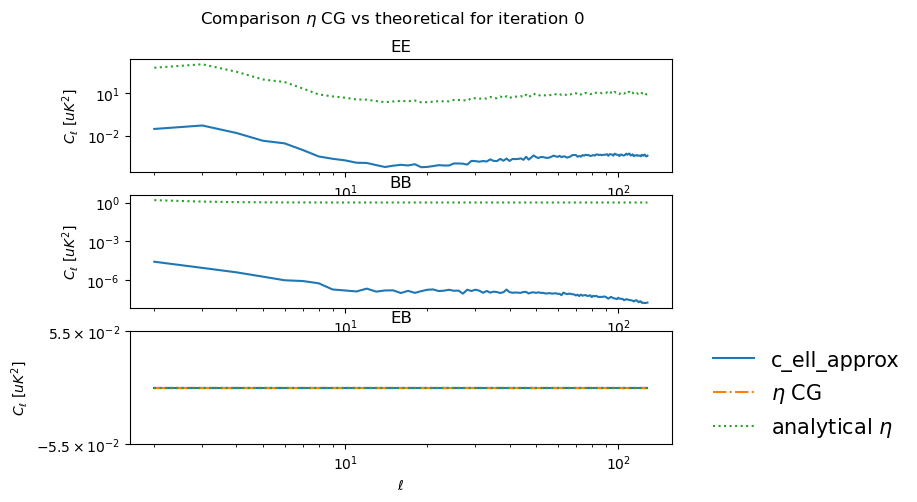

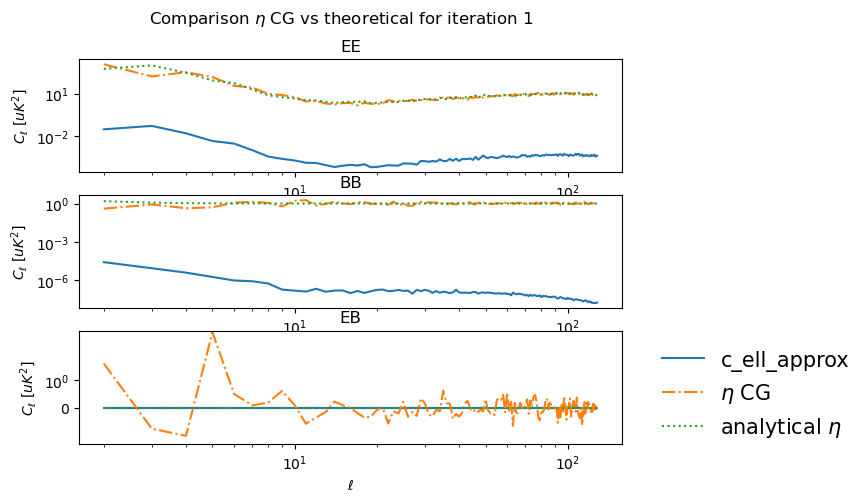

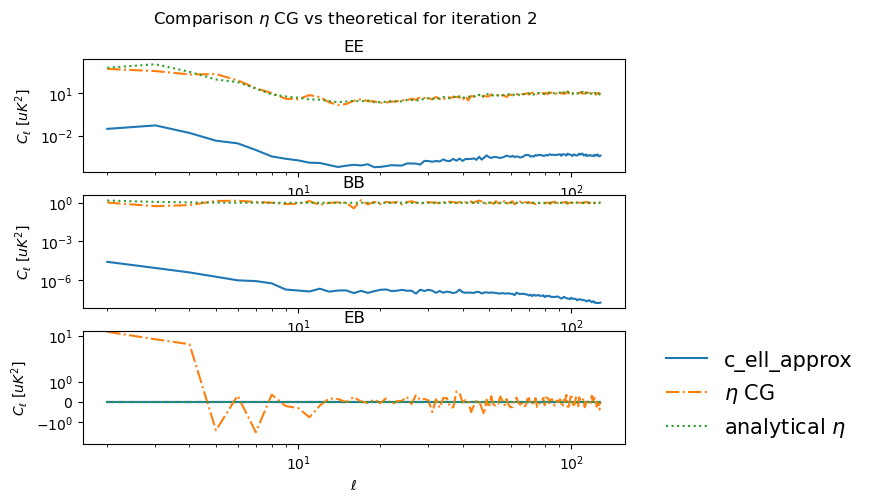

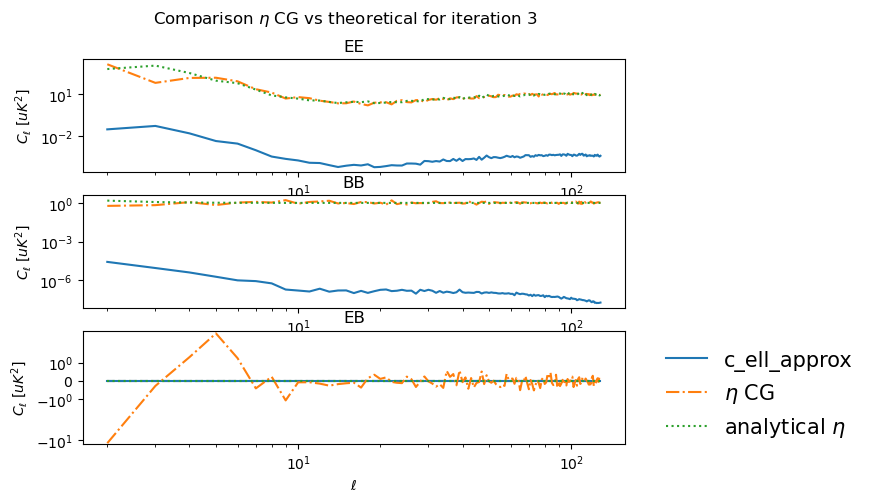

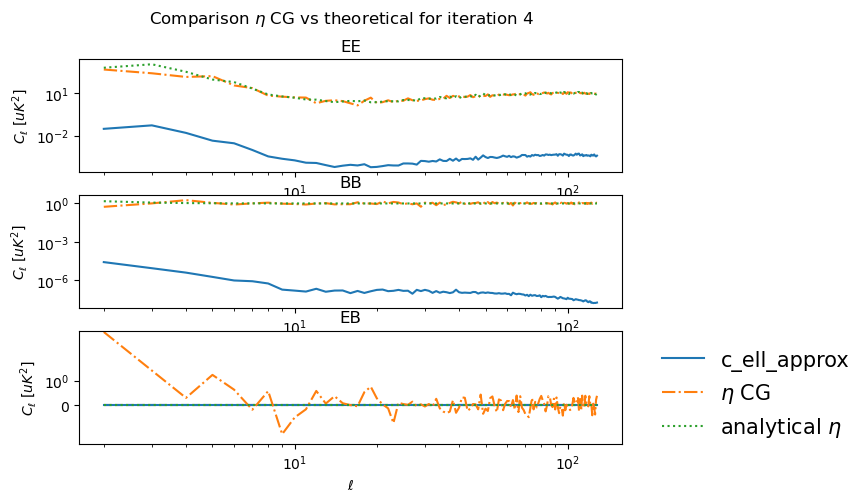

In [39]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

for iteration in range(number_iterations_sampling):
    covariance_noise = np.zeros_like(c_ell_approx)

    mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
    mixing_matrix_sampled = mixing_matrix_obj.get_B()
    BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
    BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
    BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

    analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + eye_Stokes_only_B/BtinvNB[0,0], red_cov_approx_matrix_sqrt)
    # analytical_eta_term = np.zeros_like(c_ell_approx)
    analytical_eta_term = micmac.get_c_ells_from_red_covariance_matrix(analytical_eta_term_cov)#[:,lmin:]



    eta_maps_extended = np.vstack([np.zeros_like(all_eta_maps[iteration,0,...]), all_eta_maps[iteration]])
    c_ells_eta = hp.anafast(eta_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    plt.figure(figsize=(7,5))
    plt.suptitle(r"Comparison $\eta$ CG vs theoretical for iteration {}".format(iteration))

    for j in range(number_correl_to_plot):
        ax = plt.subplot(311+j)
        plt.title(list_correl[j])
        
        plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
        
        plt.plot(ell_arange, c_ell_approx[j,lmin:], label='c_ell_approx')
        plt.plot(ell_arange, c_ells_eta[j,:], '-.', label=r"$\eta$ CG")
        
        plt.plot(ell_arange, analytical_eta_term[j,:], ':', label=r"analytical $\eta$")

        if nstokes == 3 and j < number_correl_to_plot-2:
            plt.xticks(color='w')

        if j <= nstokes-1:
            plt.loglog()
            # plt.ylim(ymin=noise_level/10.)
        else:
            plt.xscale('log')
            plt.yscale('symlog')
        # plt.legend()
        if j == position_legend:
            plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        
        plt.ylabel("$C_\ell$ [$uK^2$]")
        if j == number_correl_to_plot-1:
            plt.xlabel(r"$\ell$")


    plt.show()

# Validation $s_c$

In [40]:
all_params_mixing_matrix_samples[0].ravel(order='F').reshape((4,2),order='F')

array([[0.33858815, 0.00979233],
       [0.02963068, 0.05147511],
       [0.00998213, 0.12913911],
       [0.00328725, 0.44076761]])

In [41]:
# [[0.33858815 0.00979233]
#  [0.02963068 0.05147511]
#  [0.00998213 0.12913911]
#  [0.00328725 0.44076761]]

In [42]:
initial_freq_maps.shape

(6, 2, 49152)

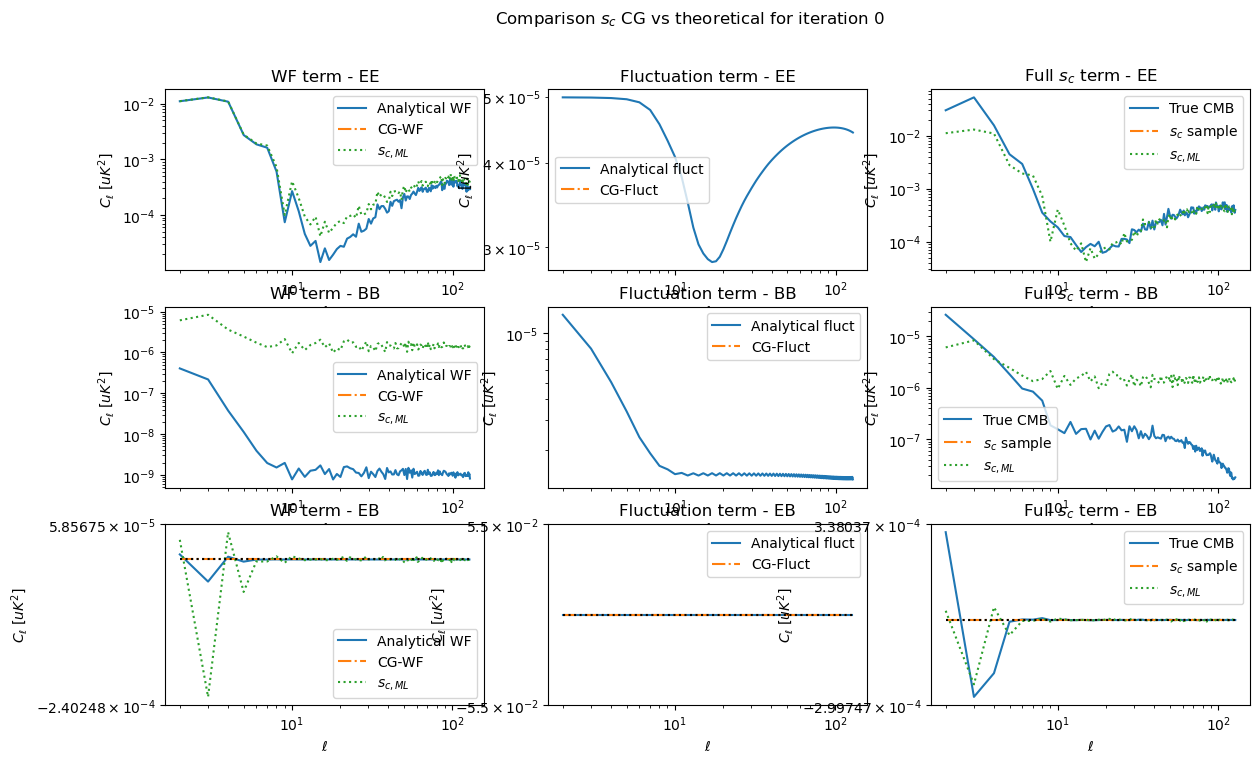

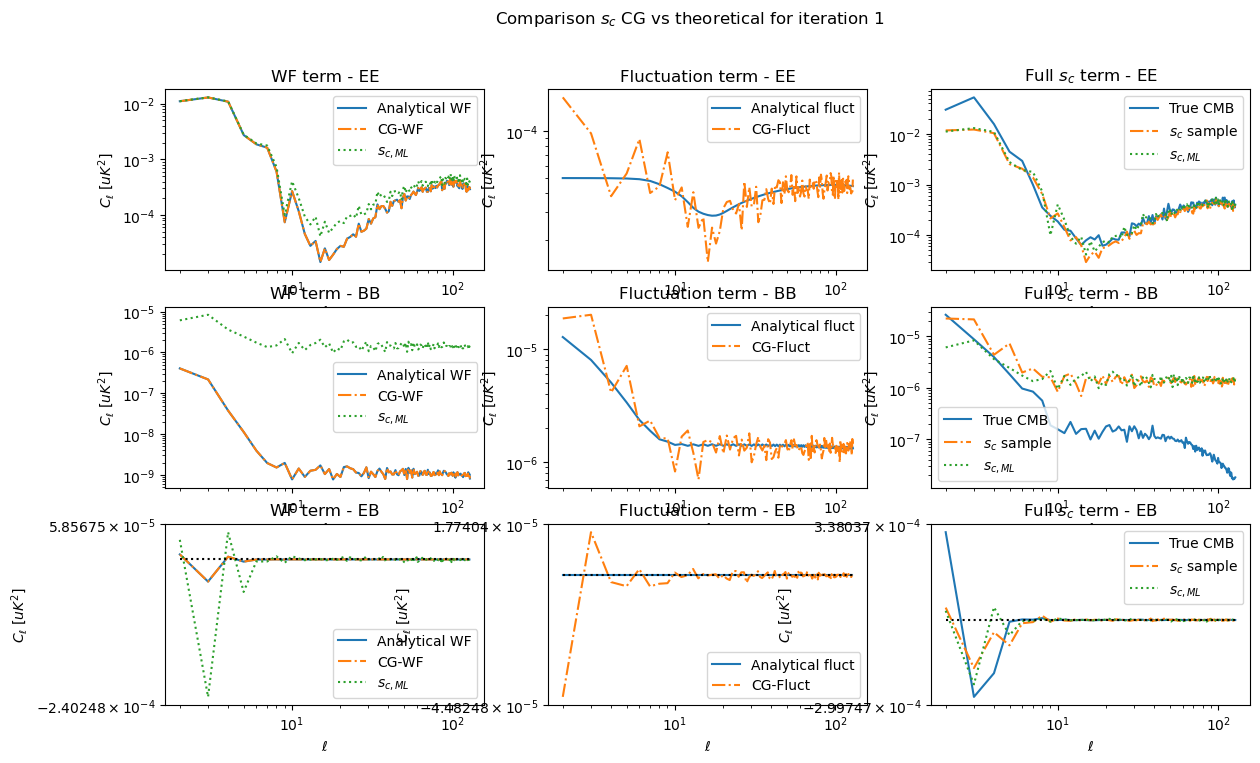

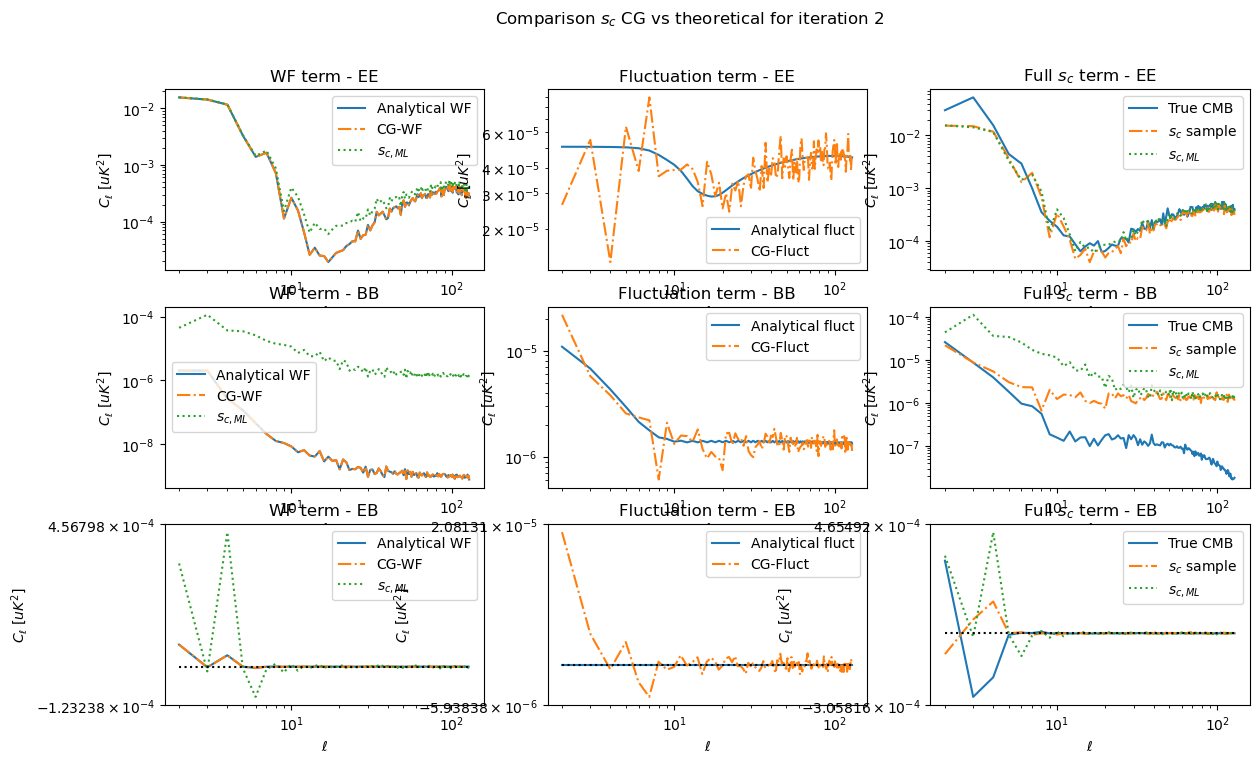

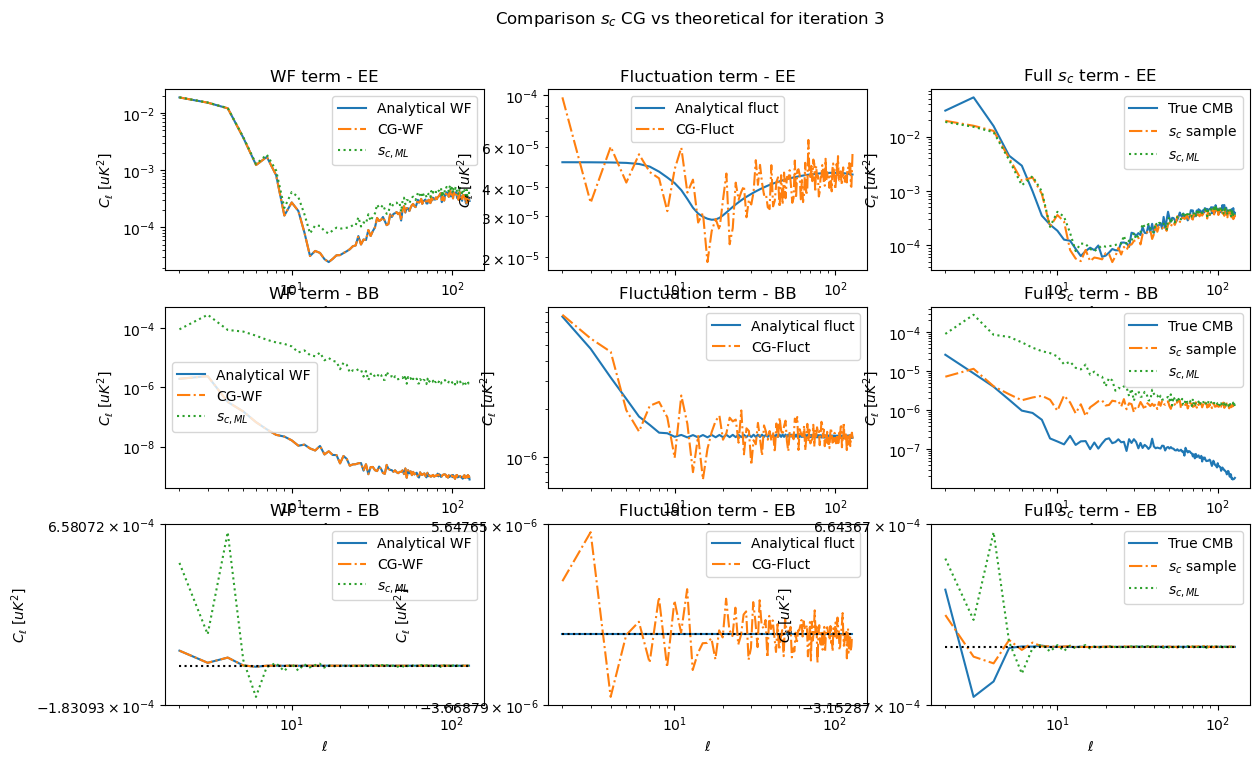

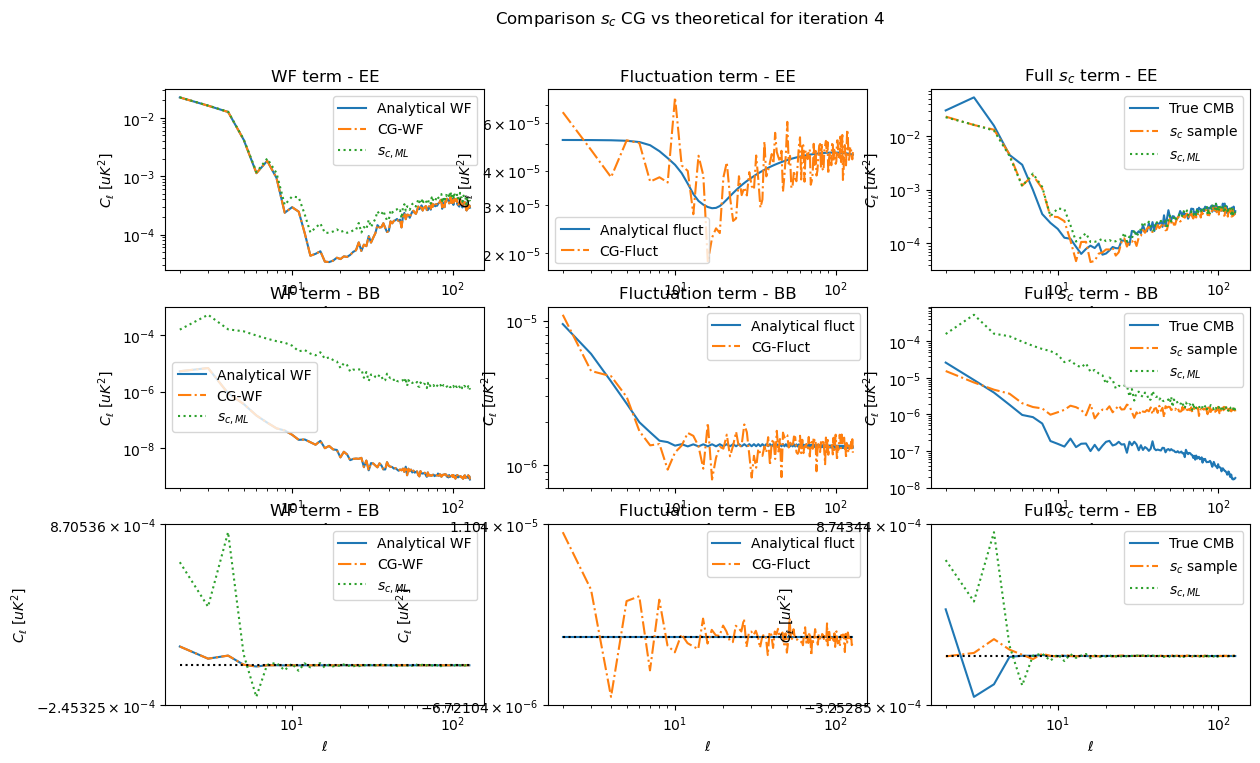

In [43]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']
# overrelaxation_param = -.89

map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=lmax, iter=n_iter)[indices_polar, lmin:]

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

for iteration in range(number_iterations_sampling):
    covariance_noise = np.zeros_like(c_ell_approx)

    

    red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration,...])[lmin:]
    mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
    if iteration != 0:
        red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration-1,...])[lmin:]
        mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration-1])
    mixing_matrix_sampled = mixing_matrix_obj.get_B()
    BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
    BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
    BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
    s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps, jax_use=False)[0, :, :]

    full_map_s_c = all_s_c_WF_maps[iteration] + all_s_c_fluct_maps[iteration]
    full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
    c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.eye(nstokes)/BtinvNB[0,0])
    analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
    analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=lmin, n_iter=n_iter)

    analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
    analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
    analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

    s_c_WF_maps_extended = np.vstack([np.zeros_like(all_s_c_WF_maps[iteration,0,...]), all_s_c_WF_maps[iteration]])
    c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    s_c_fluct_maps_extended = np.vstack([np.zeros_like(all_s_c_fluct_maps[iteration,0,...]), all_s_c_fluct_maps[iteration]])
    c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    # s_c_recovered = all_s_c_WF_maps[iteration,...] + np.sqrt(1-overrelaxation_param**2)*all_s_c_fluct_maps[iteration,...] + overrelaxation_param*(s_c_recovered-all_s_c_WF_maps[iteration,...])
    s_c_recovered = all_s_c_WF_maps[iteration,...] + all_s_c_fluct_maps[iteration,...]
    s_c_recovered_ext = np.vstack([np.zeros_like(s_c_recovered[0]),s_c_recovered])
    c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    plt.figure(figsize=(14,8))
    plt.suptitle(r"Comparison $s_c$ CG vs theoretical for iteration {}".format(iteration))

    for j in range(number_correl_to_plot):
        plt.subplot(331+3*j)
        plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, analytical_WF_cells[j,:], label='Analytical WF')
        plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ells_s_c_WF[j,:], '-.', label='CG-WF')
        plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
        if j <= nstokes-1:
            plt.loglog()
        else:
            plt.xscale('log')
            plt.yscale('symlog')
            plt.plot([lmin,lmax+1], [0,0], 'k:')
        plt.title('WF term - {}'.format(list_correl[j]))
        plt.ylabel("$C_\ell$ [$uK^2$]")
        plt.xlabel(r"$\ell$")
        plt.legend()

        plt.subplot(332+3*j)
        plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct')
        plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c_fluct[j,:], '-.', label='CG-Fluct')

        if j <= nstokes-1:
            plt.loglog()
        else:
            plt.xscale('log')
            plt.yscale('symlog')
            plt.plot([lmin,lmax+1], [0,0], 'k:')
        plt.title('Fluctuation term - {}'.format(list_correl[j]))
        plt.ylabel("$C_\ell$ [$uK^2$]")
        plt.xlabel(r"$\ell$")
        plt.legend()
        
        plt.subplot(333+3*j)
        plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ell_true_CMB[j,:], label='True CMB')
        plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')
        plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')

        if j <= nstokes-1:
            plt.loglog()
            plt.plot([lmin,lmax+1], [0,0], 'k:')
        else:
            plt.xscale('log')
            plt.yscale('symlog')
            plt.plot([lmin,lmax+1], [0,0], 'k:')
        plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
        plt.ylabel("$C_\ell$ [$uK^2$]")
        
        plt.xlabel(r"$\ell$")
        plt.legend()


    plt.show()

In [44]:
mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[0])
mixing_matrix_sampled = mixing_matrix_obj.get_B()
micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps, jax_use=False)[0]

array([[ 0.7298901 , -0.35684297,  0.59709234, ..., -0.09818427,
         0.88980885,  0.19160995],
       [-1.10399932,  0.82526093,  0.10743198, ...,  0.58813639,
        -0.20857175,  0.01668964]])

# Plot $C$

In [45]:
map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=lmax, iter=n_iter)[indices_polar, lmin:]

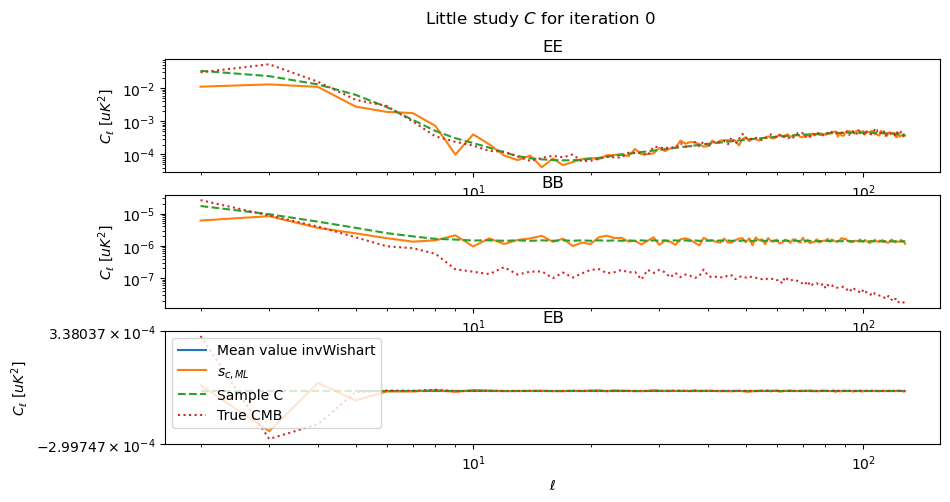

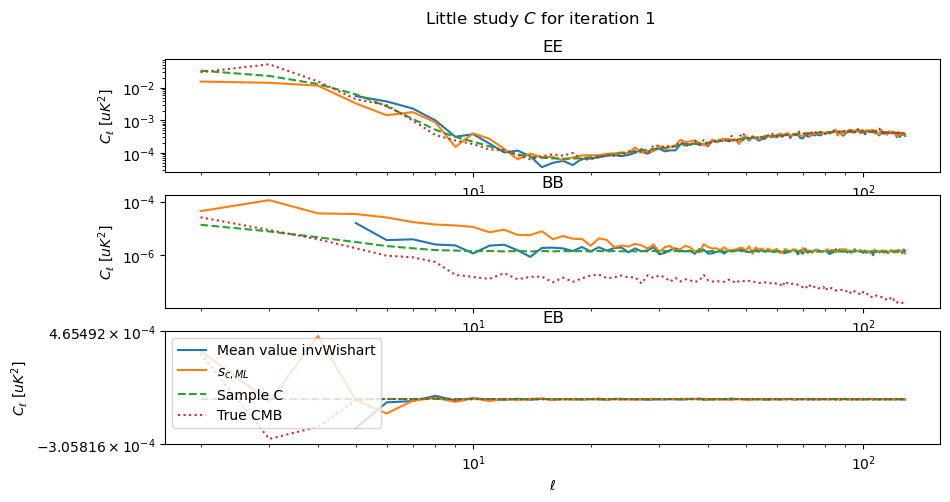

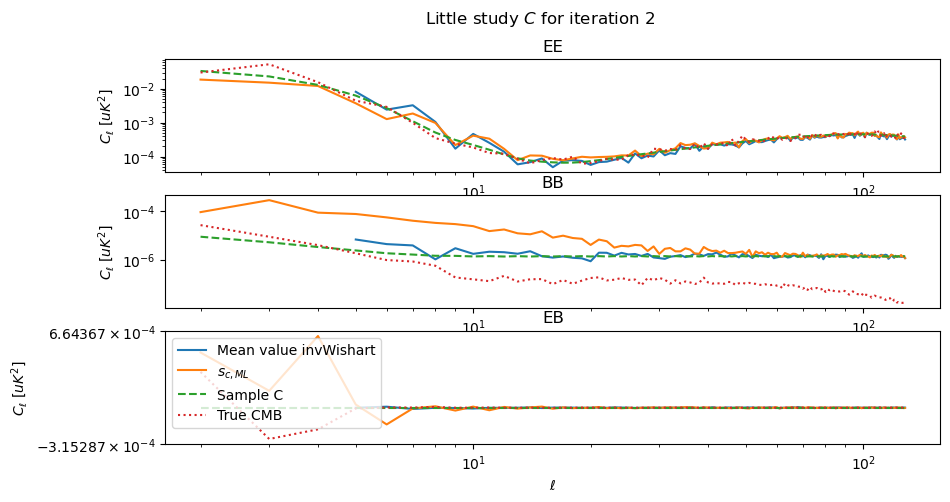

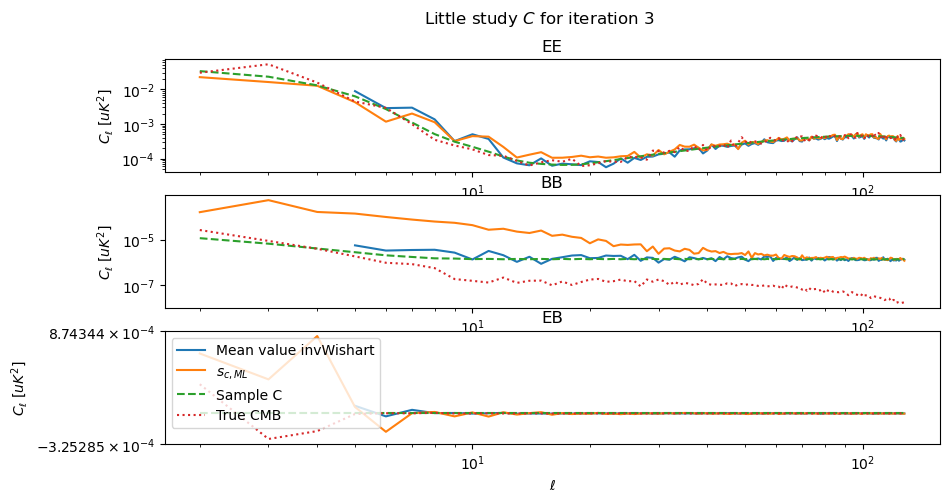

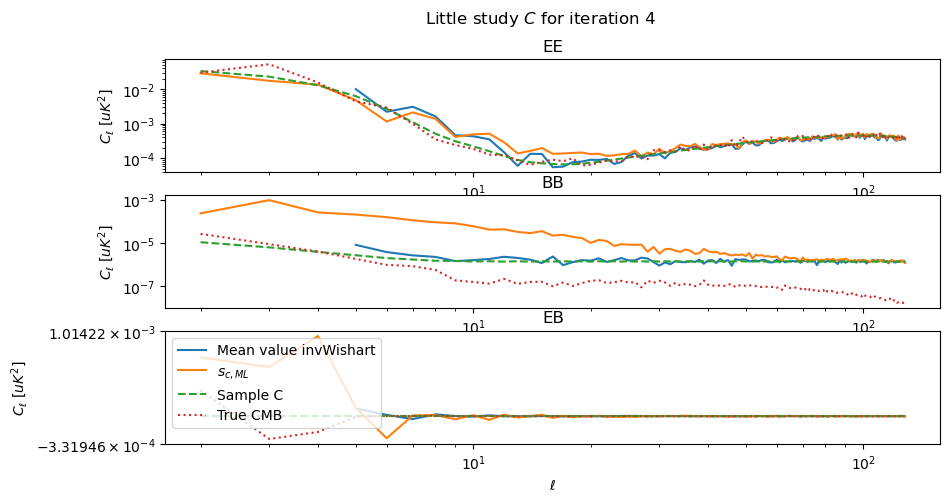

In [46]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin
min_value_mean = 3
factor_mean = (2*ell_arange[min_value_mean:] + 1)/(2*ell_arange[min_value_mean:] + 1 - 2 - 2*nstokes)

for iteration in range(number_iterations_sampling):
    covariance_noise = np.zeros_like(c_ell_approx)

    mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
    mixing_matrix_sampled = mixing_matrix_obj.get_B()
    BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
    BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
    BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
    s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps, jax_use=False)[0]
    full_map_s_c = all_s_c_WF_maps[iteration] + all_s_c_fluct_maps[iteration]
    # red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration,...])[lmin:]

    full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
    c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    full_map_s_c_extended = np.vstack([np.zeros_like(full_map_s_c[0,...]), full_map_s_c])
    c_ell_s_c = hp.anafast(full_map_s_c_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    plt.figure(figsize=(10,5))
    plt.suptitle(r"Little study $C$ for iteration {}".format(iteration))

    for j in range(number_correl_to_plot):
        ax = plt.subplot(311+j)
        plt.title(list_correl[j])

        plt.plot(ell_arange[min_value_mean:], c_ell_s_c[j,min_value_mean:]*factor_mean, label='Mean value invWishart')
        plt.plot(ell_arange, c_ell_s_cML[j,...], label='$s_{c,ML}$')
        plt.plot(ell_arange, all_cell_samples[iteration,j,lmin:], '--', label='Sample C')
        plt.plot(ell_arange, c_ell_true_CMB[j,...], ':', label='True CMB')
        
        plt.ylabel("$C_\ell$ [$uK^2$]")
        if j == number_correl_to_plot-1:
            plt.xlabel(r"$\ell$")
            plt.legend()
            plt.xscale('log')
            plt.yscale('symlog')
        else:
            plt.loglog()


    plt.show()

# Studying $r$

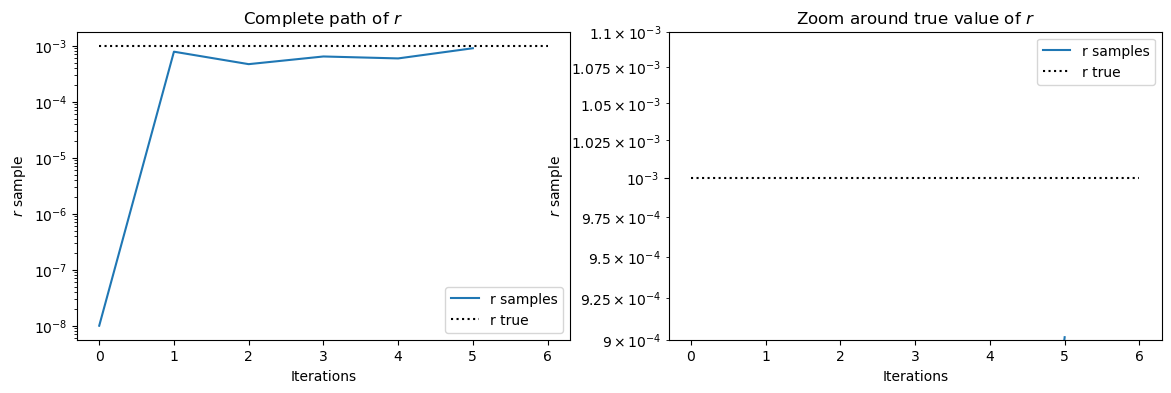

In [47]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(np.arange(number_iterations_sampling+1), all_r_samples, label='r samples')
plt.plot([0, number_iterations_sampling+1], [r_true,r_true], 'k:', label='r true')
plt.yscale('log')
plt.xlabel("Iterations")
plt.ylabel('$r$ sample')
plt.title('Complete path of $r$')
plt.legend()

plt.subplot(122)
plt.plot(np.arange(number_iterations_sampling+1), all_r_samples, label='r samples')
plt.plot([0, number_iterations_sampling+1], [r_true,r_true], 'k:', label='r true')
plt.yscale('log')
plt.xlabel("Iterations")
plt.ylabel('$r$ sample')
plt.title('Zoom around true value of $r$')
plt.legend()
plt.ylim(ymin=r_true*.9, ymax=r_true*1.1)
plt.show()

In [48]:
# initial_freq_maps_only_B = np.copy(initial_freq_maps)
# c_ell_select_only_Bmodes = np.zeros((6,lmax+1))
# c_ell_select_only_Bmodes[2,lmin:] = 1
# red_cov_select_Bmodes = micmac.get_reduced_matrix_from_c_ell(c_ell_select_only_Bmodes[indices_polar,...])[lmin:,...]
# for freq in range(number_frequencies):
#     initial_freq_maps_only_B[freq] = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(np.copy(initial_freq_maps[freq]), red_cov_select_Bmodes, lmin=2, n_iter=n_iter)[1:,...]

# input_cmb_maps_only_B = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(np.copy(input_cmb_maps[0]), red_cov_select_Bmodes, lmin=2, n_iter=n_iter)[1:,...]

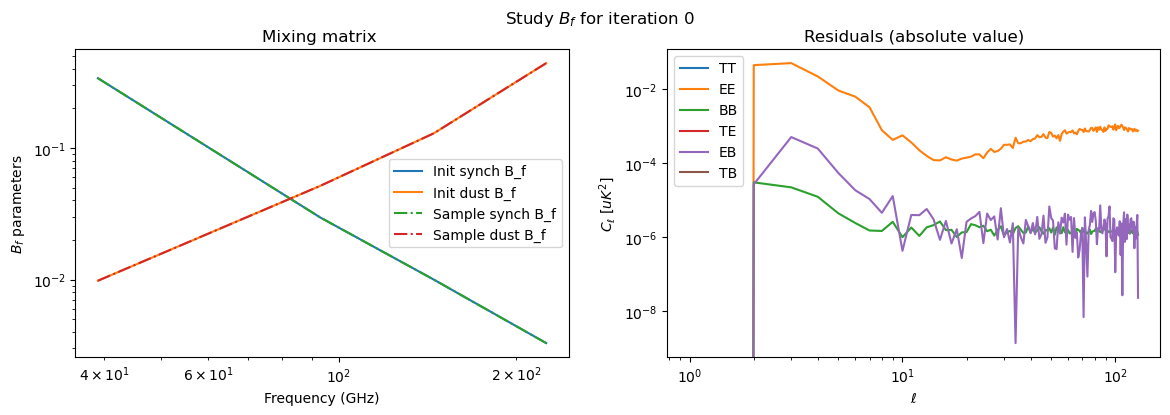

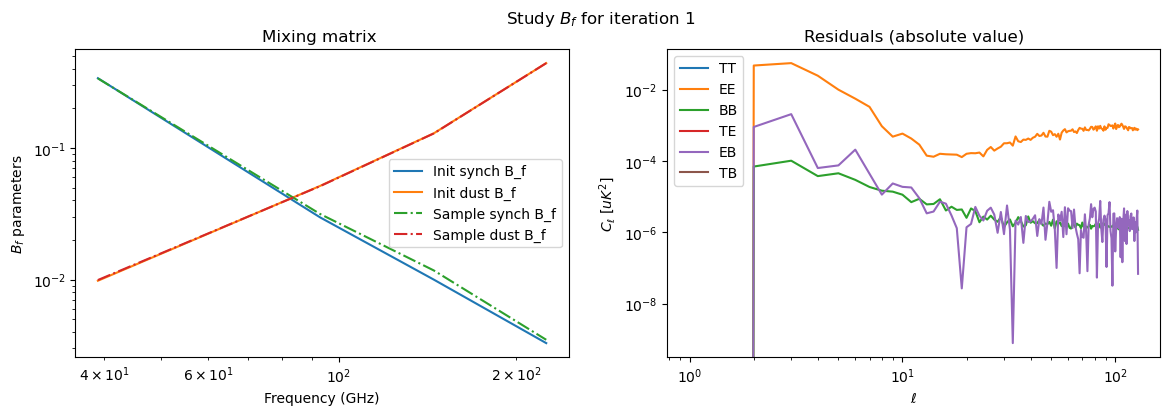

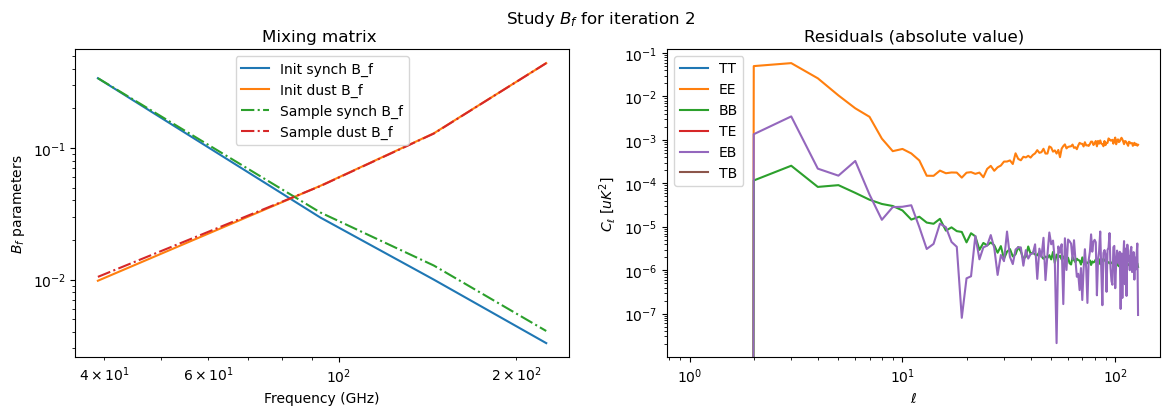

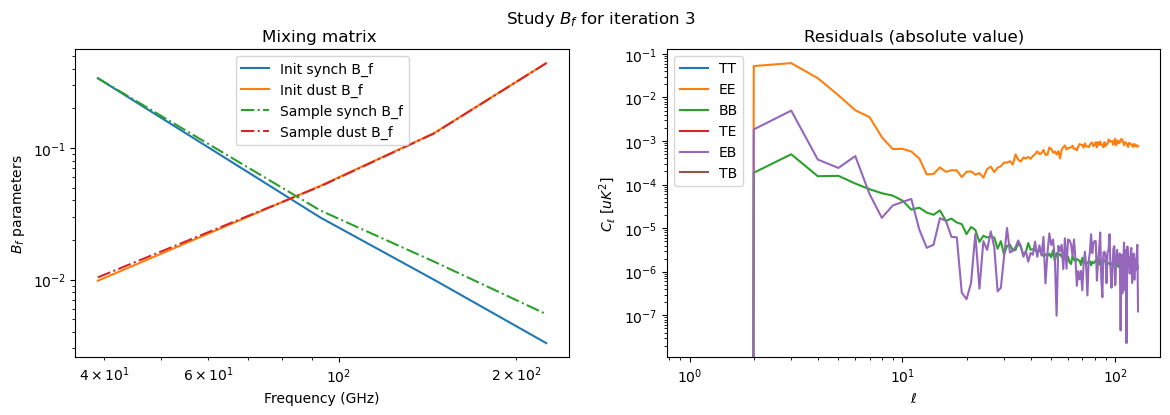

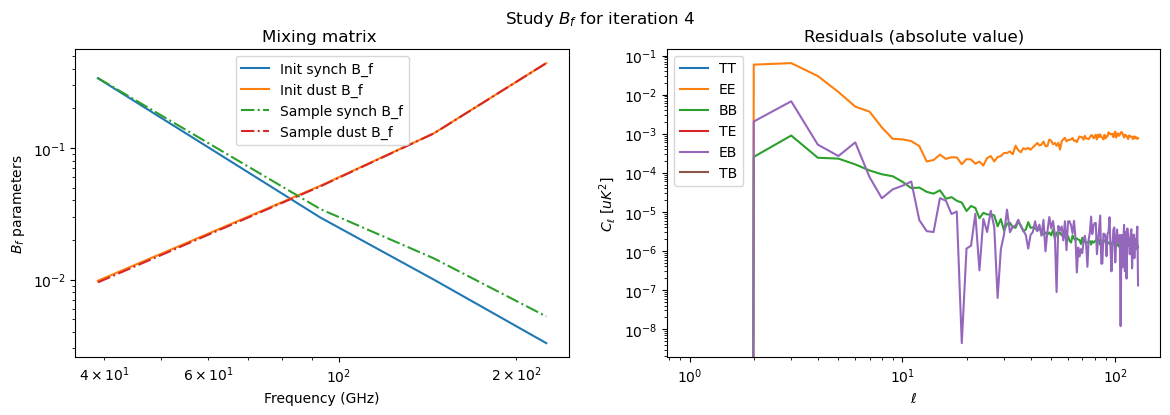

In [49]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin
min_value_mean = 3
factor_mean = (2*ell_arange[min_value_mean:] + 1)/(2*ell_arange[min_value_mean:] + 1 - 2 - 2*nstokes)

frequency_Bf = instrument['frequency'][1:-1]

for iteration in range(number_iterations_sampling):
    covariance_noise = np.zeros_like(c_ell_approx)

    mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
    mixing_matrix_sampled = mixing_matrix_obj.get_B()
    BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
    BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
    BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
    s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps, jax_use=False)[0]
    # s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps_only_B, jax_use=False)[0]

    full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
    c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    first_residual = input_cmb_maps[0] - s_cML
    # first_residual = input_cmb_maps_only_B - s_cML


    c_ell_first_residual = hp.anafast(np.vstack([np.zeros_like(first_residual[0]),first_residual]), lmax=lmax, iter=n_iter)
    ell_arange = np.arange(c_ell_first_residual.shape[1])
    
    plt.figure(figsize=(14,4))
    plt.suptitle(r"Study $B_f$ for iteration {}".format(iteration))

    plt.subplot(121)
    plt.plot(frequency_Bf, init_params[:,0], label='Init synch B_f')
    plt.plot(frequency_Bf, init_params[:,1], label='Init dust B_f')
    plt.plot(frequency_Bf, all_params_mixing_matrix_samples[iteration,:,0], '-.', label='Sample synch B_f')
    plt.plot(frequency_Bf, all_params_mixing_matrix_samples[iteration,:,1], '-.', label='Sample dust B_f')
    plt.title("Mixing matrix ")
    plt.xlabel('Frequency (GHz)')
    plt.ylabel("$B_f$ parameters")
    plt.legend()
    plt.loglog()

    plt.subplot(122)
    plt.plot(ell_arange, np.abs(c_ell_first_residual.T))
    # plt.plot(ell_arange, np.abs(c_ell_first_residual).T)
    plt.title("Residuals (absolute value)")
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel("$\ell$")
    plt.loglog()
    plt.legend(['TT', 'EE', 'BB', 'TE', 'EB', 'TB'])
    

    plt.show()

/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_61410/2084740916.py:55: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


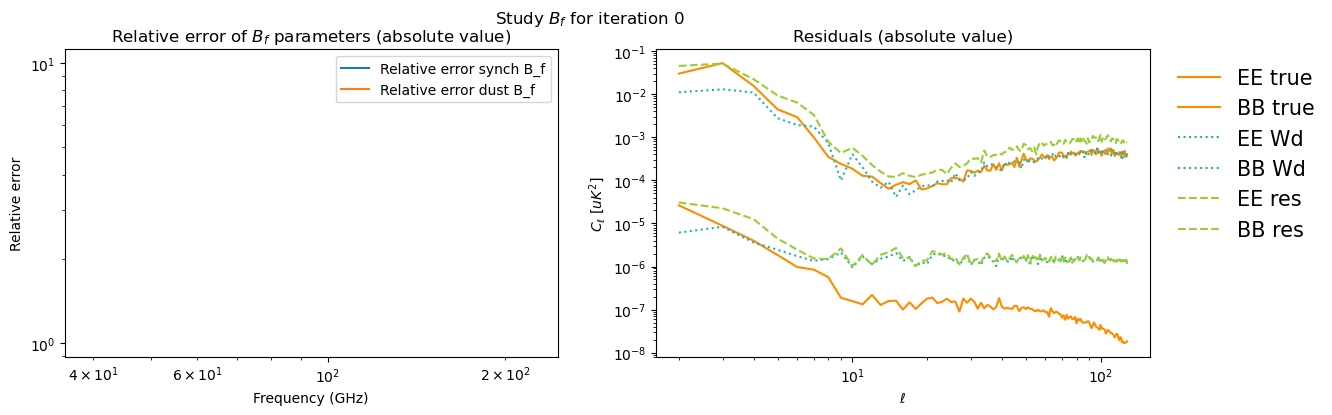

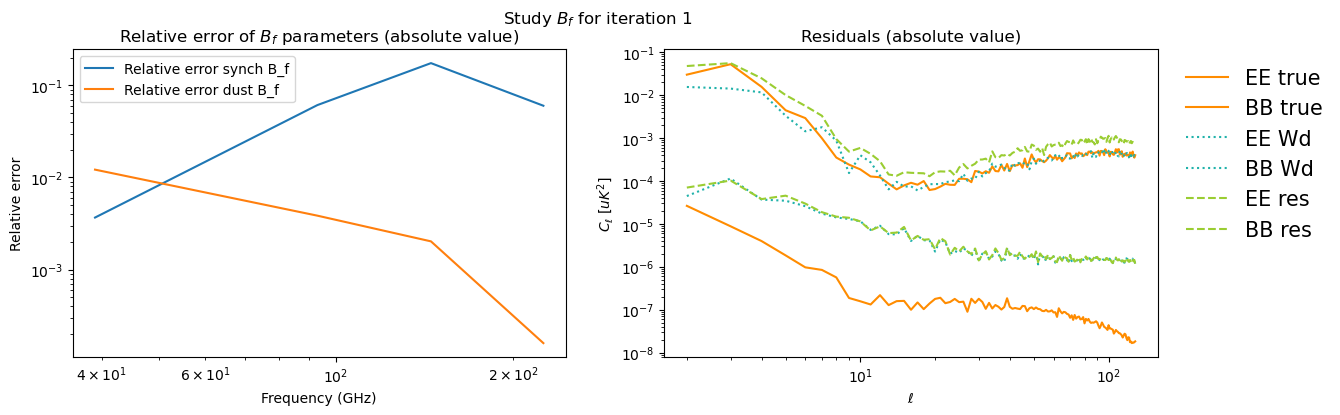

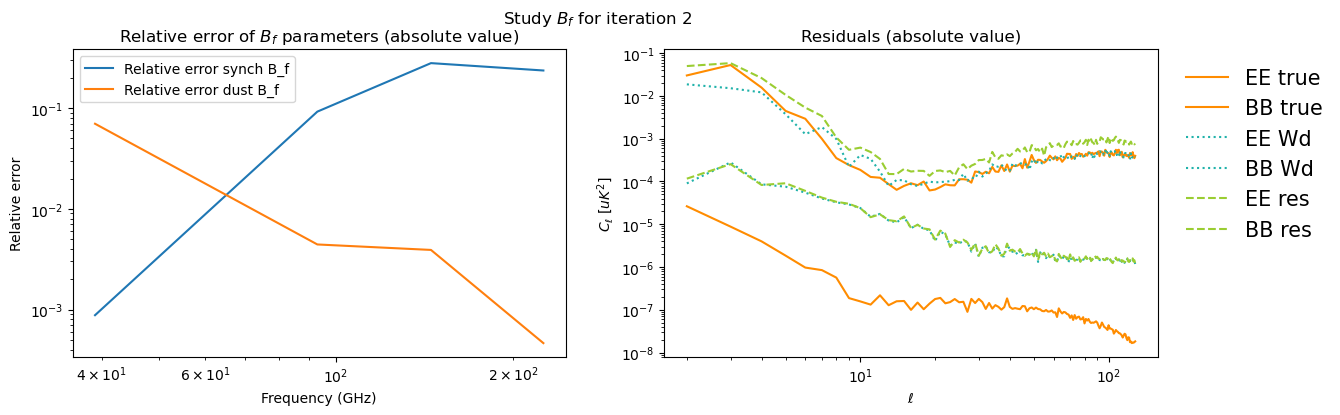

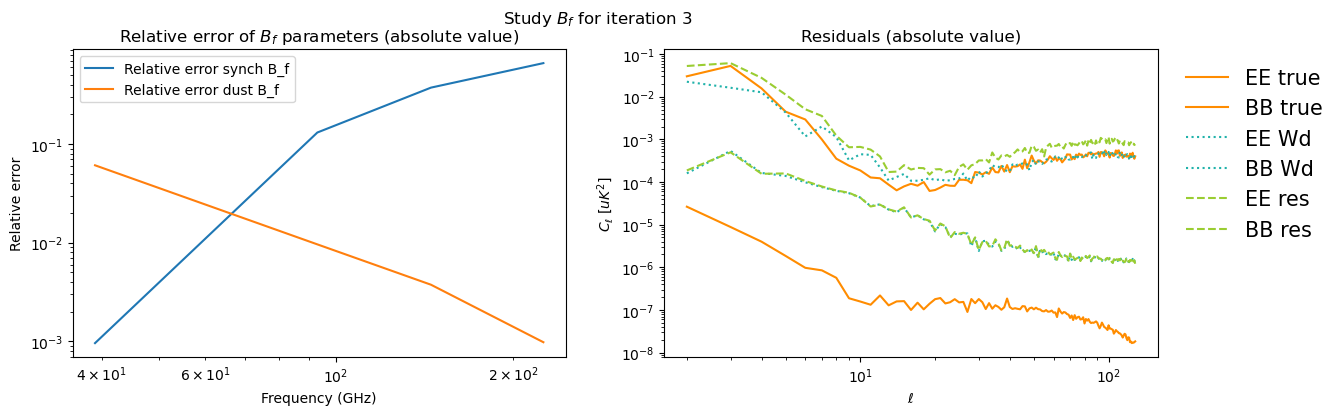

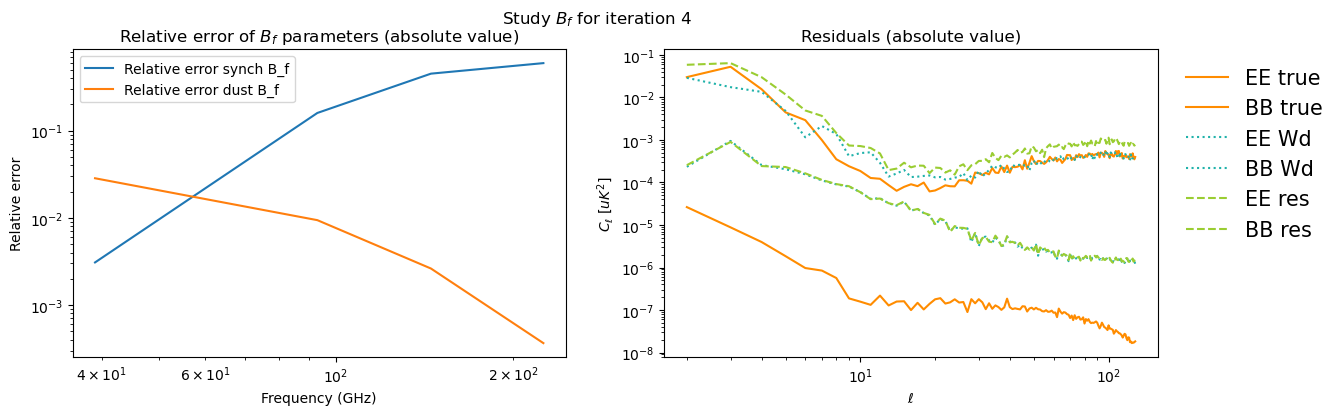

In [50]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin
min_value_mean = 3
factor_mean = (2*ell_arange[min_value_mean:] + 1)/(2*ell_arange[min_value_mean:] + 1 - 2 - 2*nstokes)

frequency_Bf = instrument['frequency'][1:-1]

for iteration in range(0,number_iterations_sampling,sub_step_sampling):
    covariance_noise = np.zeros_like(c_ell_approx)

    mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
    mixing_matrix_sampled = mixing_matrix_obj.get_B()
    BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
    BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
    BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
    s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps, jax_use=False)[0]
    # s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps_only_B, jax_use=False)[0]

    full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
    c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    first_residual = input_cmb_maps[0] - s_cML
    # first_residual = input_cmb_maps[0] - (all_s_c_WF_maps[iteration]+all_s_c_fluct_maps[iteration])
    # first_residual = initial_freq_maps - s_cML

    full_map_true_CMB_2_extended = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
    c_ell_true_CMB_2 = hp.anafast(full_map_true_CMB_2_extended, lmax=lmax, iter=n_iter)#[:,lmin:]

    c_ell_s_cML = hp.anafast(np.vstack([np.zeros_like(s_cML[0]),s_cML]), lmax=lmax, iter=n_iter)

    c_ell_first_residual = hp.anafast(np.vstack([np.zeros_like(first_residual[0]),first_residual]), lmax=lmax, iter=n_iter)
    ell_arange = np.arange(c_ell_first_residual.shape[1])
    
    
    relative_error_synch = np.abs((init_params[:,0]-all_params_mixing_matrix_samples[iteration,:,0])/init_params[:,0])
    relative_error_dust = np.abs((init_params[:,1]-all_params_mixing_matrix_samples[iteration,:,1])/init_params[:,1])

    plt.figure(figsize=(14,4))
    plt.suptitle(r"Study $B_f$ for iteration {}".format(iteration))

    plt.subplot(121)

    # plt.plot([frequency_Bf[1],frequency_Bf[number_frequencies-2]], [0,0], 'k:', label='0')
    plt.plot(frequency_Bf, relative_error_synch, label='Relative error synch B_f')
    plt.plot(frequency_Bf, relative_error_dust, label='Relative error dust B_f')
    # plt.plot(frequency_Bf, all_params_mixing_matrix_samples[iteration,:,0], '-.', label='Sample synch B_f')
    # plt.plot(frequency_Bf, all_params_mixing_matrix_samples[iteration,:,1], '-.', label='Sample dust B_f')
    plt.title("Relative error of $B_f$ parameters (absolute value)")
    plt.xlabel('Frequency (GHz)')
    plt.ylabel("Relative error")
    plt.legend()
    plt.xscale('log')
    # plt.yscale('symlog')
    plt.yscale('log')

    plt.subplot(122)
    # plt.plot(ell_arange[lmin:], np.abs(c_ell_true_CMB_2).T, color='darkorange')
    # plt.plot(ell_arange[lmin:], np.abs(c_ell_s_cML[indices_polar,lmin:]).T, ':', color='lightseagreen')
    # plt.plot(ell_arange[lmin:], np.abs(c_ell_first_residual[indices_polar,lmin:]).T, '--', color='yellowgreen')
    plt.plot(ell_arange[lmin:], np.abs(c_ell_true_CMB_2[partial_indices_polar,lmin:]).T, color='darkorange')
    plt.plot(ell_arange[lmin:], np.abs(c_ell_s_cML[partial_indices_polar,lmin:]).T, ':', color='lightseagreen')
    plt.plot(ell_arange[lmin:], np.abs(c_ell_first_residual[partial_indices_polar,lmin:]).T, '--', color='yellowgreen')
    # plt.plot(ell_arange[lmin:], np.abs(c_ell_first_residual[indices_polar,lmin:]/c_ell_true_CMB_2).T, '--')
    
    # plt.plot(ell_arange, np.abs(c_ell_first_residual).T)
    plt.title("Residuals (absolute value)")
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel("$\ell$")
    plt.loglog()
    # plt.legend(['TT', 'EE', 'BB', 'TE', 'EB', 'TB'])
    # plt.legend(['EE true', 'BB true', 'EB true', 'EE res', 'BB res', 'EB res'])
    # plt.legend(['EE true', 'BB true', 'EB true', 'EE Wd', 'BB Wd', 'EB Wd', 'EE res', 'BB res', 'EB res'], bbox_to_anchor=(1.02, 1), loc="upper left", prop={'size': 15}, frameon=False)
    plt.legend(['EE true', 'BB true', 'EE Wd', 'BB Wd', 'EE res', 'BB res'], bbox_to_anchor=(1.02, 1), loc="upper left", prop={'size': 15}, frameon=False)
    # plt.legend(['EE Wd', 'BB Wd', 'EB Wd', 'EE Wd', 'BB res', 'EB res'])
    # plt.legend(['EE Wd', 'BB Wd', 'EB Wd', 'EE Wd', 'BB res', 'EB res'])


    plt.show()